In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# This code demonstrates how to fine-tune Vision Transformer (ViT) and SWIN models on the CIFAR-10 dataset and apply Grad-CAM visualization.

## 1. Setup Environment

# !pip install torch torchvision timm pytorch-gradcam
# !pip install git+https://github.com/jacobgil/pytorch-grad-cam.git
#!pip show pytorch-gradcam
#!ls /usr/local/lib/python3.11/dist-packages/

## 2. Import Libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import timm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np

## 3. Data Preparation

# Define transforms
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])


# Set up normalization based on the cifar10 dataset
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
size = (224, 224)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


In [3]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

## 4. Model Setup

# Load pre-trained models
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify classification heads
# For ViT
vit_model.head = nn.Linear(vit_model.head.in_features, 10)

# multi GPU setup
# vit_model = nn.DataParallel(vit_model)

# Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [4]:
from tqdm import tqdm
from torch.amp import autocast

def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []
    eval_losses = []
    eval_accuracies = []
    lrs = [] 
    best_acc = 0.0

    scaler = torch.amp.GradScaler(device='cuda', enabled=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # 記錄當前學習率
        current_lr = scheduler.get_last_lr()[0]
        lrs.append(current_lr)

        for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda', enabled=True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        scheduler.step()

        avg_train_loss = running_loss / len(trainloader)
        train_acc = correct / total * 100
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        print(f"Epoch {epoch+1}, LR: {current_lr:.6e}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}")

        # Evaluate
        eval_loss, eval_acc = evaluate_model(model, testloader, criterion)
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_acc)

        if eval_acc > best_acc:
            best_acc = eval_acc
            torch.save(model.state_dict(), "./ViT/best_ViT_model.pth")
            print("🧠 Best model updated.")

    return train_losses, train_accuracies, eval_losses, eval_accuracies, lrs
    
def evaluate_model(model, testloader, criterion):
    model.eval()
    total = 0
    correct = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    print(f"Eval Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


In [ ]:
# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
vit_optimizer = optim.AdamW(vit_model.parameters(), lr=5e-5) # 7e-4, 5e-5

# Train models
print("Training Vision Transformer...") # 23m37s
train_losses, train_accuracies, eval_losses, eval_accuracies, lrs = train_model(vit_model, trainloader, testloader, criterion, vit_optimizer, num_epochs=10)

Training Vision Transformer...


Epoch 1: 100%|██████████| 391/391 [02:02<00:00,  3.19it/s]


Epoch 1, LR: 5.000000e-05, Train Loss: 0.1374, Train Acc: 95.65


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s]


Eval Loss: 0.0899, Accuracy: 97.13%
🧠 Best model updated.


Epoch 2: 100%|██████████| 391/391 [02:01<00:00,  3.20it/s]


Epoch 2, LR: 4.877641e-05, Train Loss: 0.0556, Train Acc: 98.11


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.53it/s]


Eval Loss: 0.0779, Accuracy: 97.51%
🧠 Best model updated.


Epoch 3: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 3, LR: 4.522542e-05, Train Loss: 0.0334, Train Acc: 98.91


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.53it/s]


Eval Loss: 0.1049, Accuracy: 97.01%


Epoch 4: 100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Epoch 4, LR: 3.969463e-05, Train Loss: 0.0251, Train Acc: 99.16


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.53it/s]


Eval Loss: 0.0654, Accuracy: 98.07%
🧠 Best model updated.


Epoch 5: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 5, LR: 3.272542e-05, Train Loss: 0.0132, Train Acc: 99.54


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.53it/s]


Eval Loss: 0.0724, Accuracy: 98.23%
🧠 Best model updated.


Epoch 6: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 6, LR: 2.500000e-05, Train Loss: 0.0079, Train Acc: 99.75


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 0.0708, Accuracy: 98.30%
🧠 Best model updated.


Epoch 7: 100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Epoch 7, LR: 1.727458e-05, Train Loss: 0.0035, Train Acc: 99.89


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.53it/s]


Eval Loss: 0.0586, Accuracy: 98.69%
🧠 Best model updated.


Epoch 8: 100%|██████████| 391/391 [01:57<00:00,  3.34it/s]


Epoch 8, LR: 1.030537e-05, Train Loss: 0.0016, Train Acc: 99.95


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 0.0565, Accuracy: 98.61%


Epoch 9: 100%|██████████| 391/391 [01:56<00:00,  3.34it/s]


Epoch 9, LR: 4.774575e-06, Train Loss: 0.0012, Train Acc: 99.97


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.54it/s]


Eval Loss: 0.0536, Accuracy: 98.74%
🧠 Best model updated.


Epoch 10: 100%|██████████| 391/391 [01:56<00:00,  3.34it/s]


Epoch 10, LR: 1.223587e-06, Train Loss: 0.0005, Train Acc: 99.99


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.53it/s]


Eval Loss: 0.0533, Accuracy: 98.78%
🧠 Best model updated.


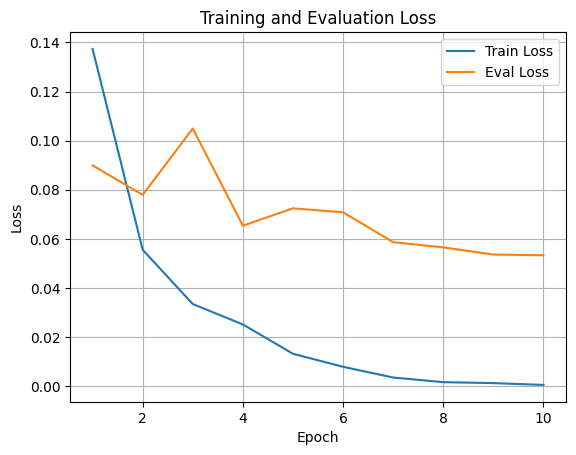

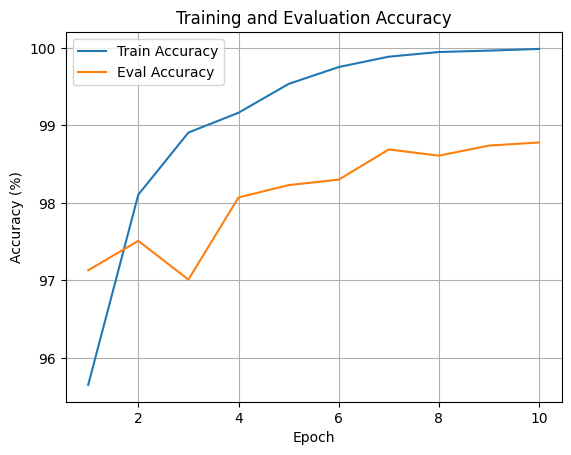

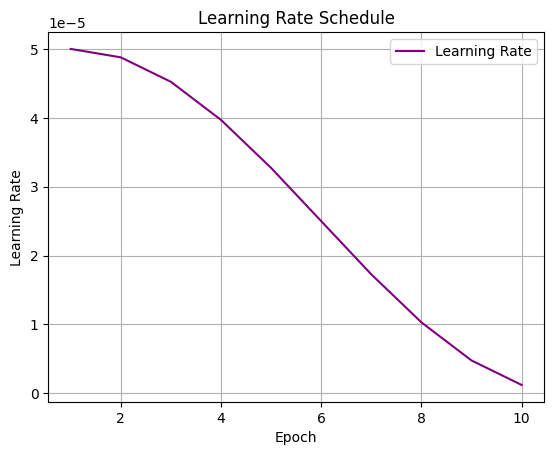

In [6]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses) + 1))

plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, eval_losses, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.savefig("./ViT/loss_curve.png")

plt.figure()
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, eval_accuracies, label='Eval Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Evaluation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("./ViT/accuracy_curve.png")

plt.figure()
plt.plot(epochs, lrs, label='Learning Rate', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid(True)
plt.savefig("./ViT/lr_schedule.png")

📦 Total Parameters: 85.81M
⚙️ FLOPs: 16.86 GFLOPs
⏱️ Avg Inference Time: 8.32 ms/image
📊 Max GPU Memory Usage: 1699.35 MB


Testing: 100%|██████████| 79/79 [00:22<00:00,  3.59it/s]


✅ Accuracy: 0.9878
❌ Top-1 Error Rate: 0.0122
📊 Classification Report:
              precision    recall  f1-score   support

    airplane       1.00      0.99      0.99      1000
  automobile       0.98      0.99      0.99      1000
        bird       0.99      0.99      0.99      1000
         cat       0.97      0.97      0.97      1000
        deer       0.99      0.99      0.99      1000
         dog       0.98      0.97      0.97      1000
        frog       0.99      0.99      0.99      1000
       horse       0.99      0.99      0.99      1000
        ship       0.99      0.99      0.99      1000
       truck       0.99      0.98      0.99      1000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



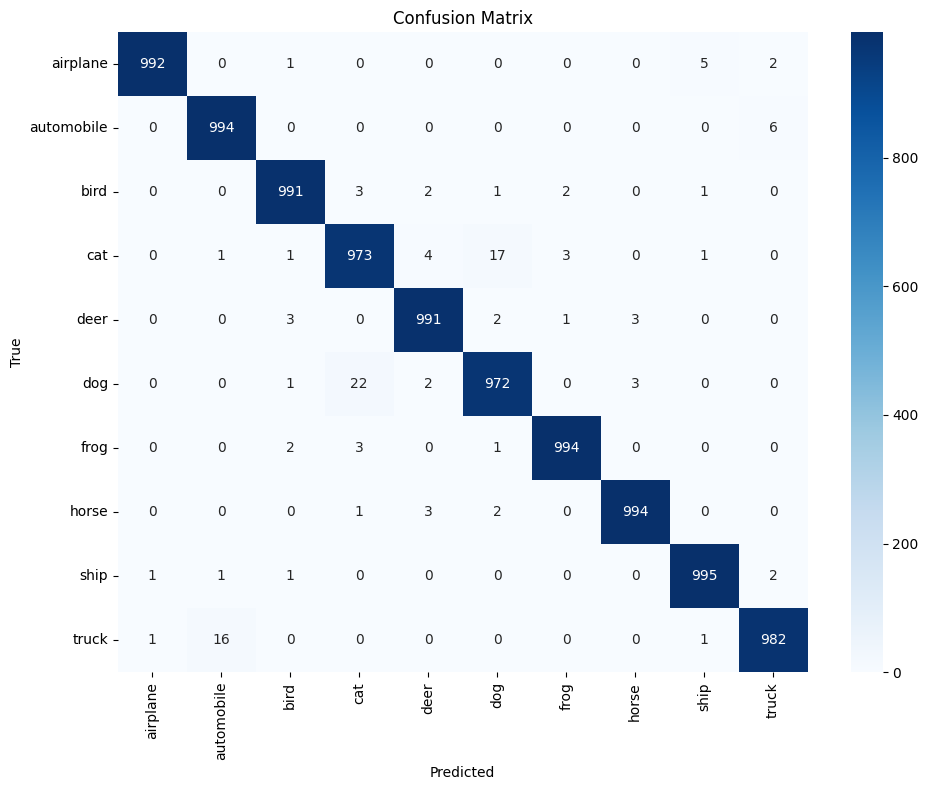

In [5]:
from timm import create_model
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from thop import profile
import time

# Load model
vit_best_model = create_model('vit_base_patch16_224', pretrained=False, num_classes=10)
vit_best_model.load_state_dict(torch.load('./ViT/best_ViT_model.pth'))
vit_best_model.to(device)
vit_best_model.eval()

# Measure Params (M)
total_params = sum(p.numel() for p in vit_best_model.parameters() if p.requires_grad)
print(f"📦 Total Parameters: {total_params/1e6:.2f}M")

# Measure FLOPs
dummy_input = torch.randn(1, 3, 224, 224).to(device)
flops, params = profile(vit_best_model, inputs=(dummy_input,), verbose=False)
print(f"⚙️ FLOPs: {flops / 1e9:.2f} GFLOPs")

# Measure Inference Time
n_test_samples = 100
n_measured = 0
total_time = 0.0

with torch.no_grad():
    for images, _ in testloader:
        images = images.to(device)
        if n_measured >= n_test_samples:
            break
        for img in images:
            if n_measured >= n_test_samples:
                break
            img = img.unsqueeze(0)
            start = time.time()
            _ = vit_best_model(img)
            total_time += time.time() - start
            n_measured += 1

avg_infer_time = total_time / n_measured * 1000  # ms
print(f"⏱️ Avg Inference Time: {avg_infer_time:.2f} ms/image")

# Measure Max GPU Memory Usage
torch.cuda.reset_peak_memory_stats()
with torch.no_grad():
    for images, _ in testloader:
        images = images.to(device)
        _ = vit_best_model(images)
        break  # Just 1 batch for GPU usage test
max_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)  # MB
print(f"📊 Max GPU Memory Usage: {max_memory:.2f} MB")

# Inference for accuracy
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Testing"):
        images = images.cuda()
        labels = labels.cuda()
        outputs = vit_best_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
top1_error = 1 - acc

print(f"✅ Accuracy: {acc:.4f}")
print(f"❌ Top-1 Error Rate: {top1_error:.4f}")

print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=testset.classes))

cfm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cfm, annot=True, fmt="d", cmap='Blues',
            xticklabels=testset.classes,
            yticklabels=testset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("./ViT/confusion_matrix.png")
plt.show()


    (11): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (ls2): Identity()
      (drop_path2): Identity()
    )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (fc_norm): Identity()
  (head_drop): Dropout(p=0.0, inplace=False)
  (head): Linear(in_features=768, out_features=10, bias=True)


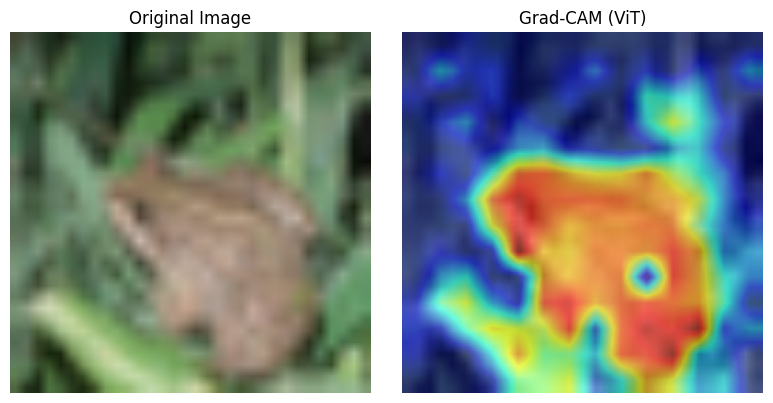

Predicted class: frog
Confidence: 100.00%


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import timm

mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])

def unnormalize_img(img_tensor):
    """Unnormalize the image tensor to [0,1] range for visualization"""
    # Only take the first image if we got a batch
    if len(img_tensor.shape) == 4:
        img_tensor = img_tensor[0]
    
    # Convert to numpy array on CPU
    img = img_tensor.cpu().numpy()
    
    # Unnormalize: multiply by std and add mean
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]
    
    # Clamp values to [0,1] range
    img = np.clip(img, 0, 1)
    
    # Convert from [C,H,W] to [H,W,C] for plotting
    img = img.transpose(1, 2, 0)
    
    return img.astype(np.float32)

def vit_reshape_transform(tensor):
    tensor = tensor[:, 1:, :]
    B, N, C = tensor.shape
    H = W = int(N ** 0.5)  # = 14 if N=196
    return tensor.permute(0, 2, 1).reshape(B, C, H, W)

selected_idx = 4
images, labels = next(iter(testloader))
single_img = images[selected_idx:selected_idx+1].to(device)

# ---------- Grad-CAM ----------
# target layer for ViT
target_layer = vit_model.blocks[-1].norm1

cam = GradCAM(model=vit_model, target_layers=[target_layer], reshape_transform=vit_reshape_transform)
grayscale_cam = cam(input_tensor=single_img, targets=None)[0]

original_img = unnormalize_img(single_img) 
cam_img = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cam_img)
plt.title("Grad-CAM (ViT)")
plt.axis('off')

plt.savefig("./ViT/gradcam_vit.png")

plt.tight_layout()
plt.show()

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
with torch.no_grad():
    outputs = vit_model(single_img)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
    top_prob, top_class = torch.max(probabilities, 0)
    print(f"Predicted class: {classes[top_class]}")
    print(f"Confidence: {top_prob.item()*100:.2f}%")


Random indices: [34, 16, 65, 30, 126]


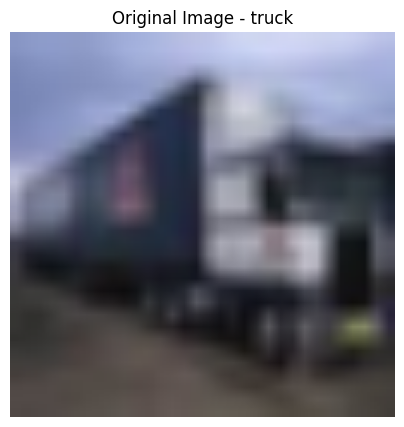

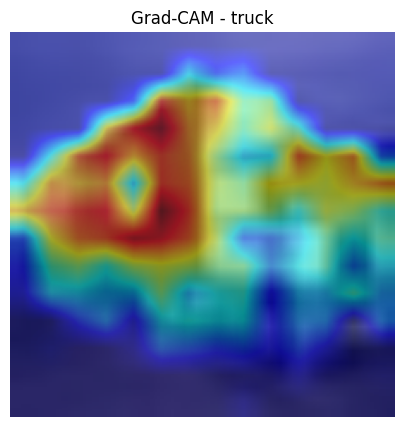

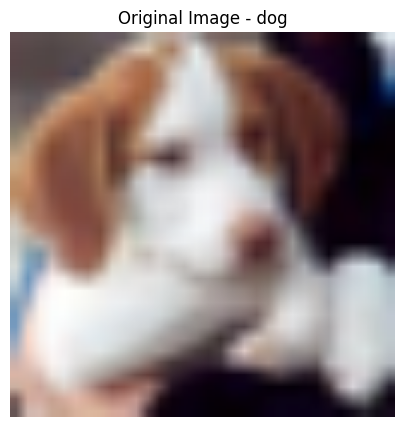

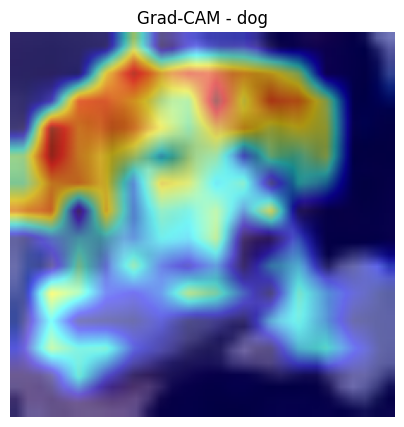

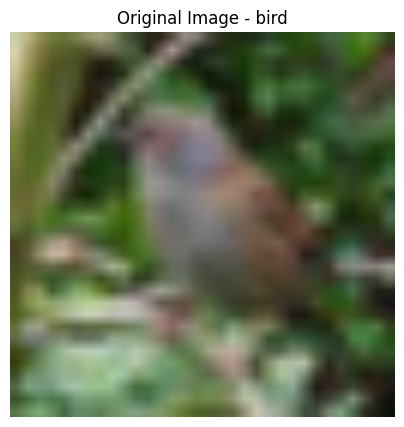

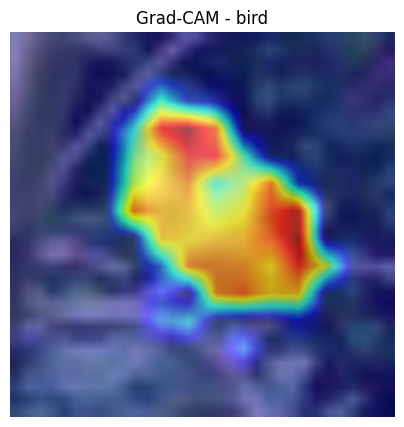

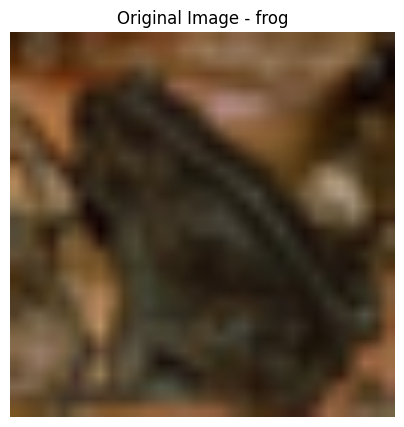

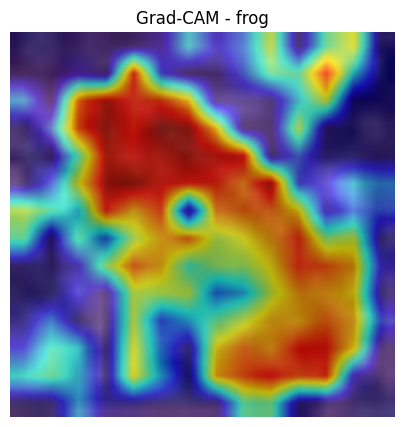

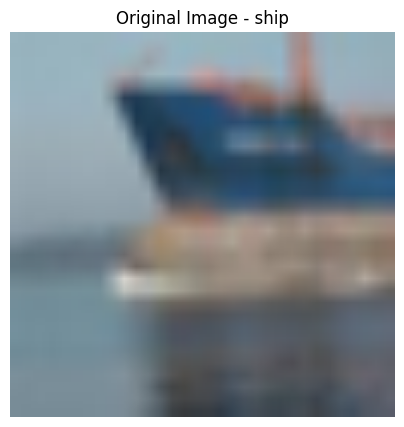

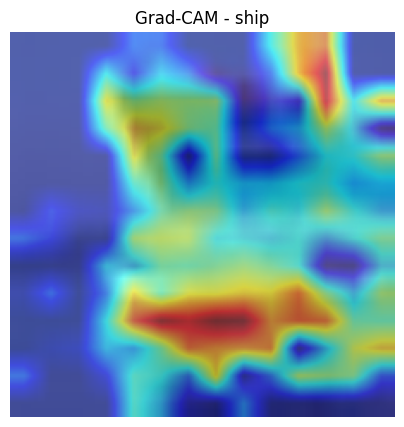

all image have been saved to ./ViT/random_images
Already saved:
  - bird_gradcam_65.png
  - bird_original_65.png
  - dog_gradcam_16.png
  - dog_original_16.png
  - frog_gradcam_30.png
  - frog_original_30.png
  - ship_gradcam_126.png
  - ship_original_126.png
  - truck_gradcam_34.png
  - truck_original_34.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import random

output_dir = "./ViT/random_images"
os.makedirs(output_dir, exist_ok=True)


images, labels = next(iter(testloader))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

seed = 1
random.seed(seed)
total_images = len(images)
random_indices = random.sample(range(total_images), 5)
print(f"Random indices: {random_indices}")

target_layer = vit_model.blocks[-1].norm1
cam = GradCAM(model=vit_model, 
              target_layers=[target_layer], 
              reshape_transform=vit_reshape_transform)

for idx in random_indices:
    single_img = images[idx:idx+1].to(device)
    img_class = classes[labels[idx]]

    grayscale_cam = cam(input_tensor=single_img, targets=None)[0]
    original_img = unnormalize_img(single_img)
    
    cam_img = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(original_img)
    plt.title(f"Original Image - {img_class}")
    plt.axis('off')
    plt.savefig(f"{output_dir}/{img_class}_original_{idx}.png", bbox_inches='tight')
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cam_img)
    plt.title(f"Grad-CAM - {img_class}")
    plt.axis('off')
    plt.savefig(f"{output_dir}/{img_class}_gradcam_{idx}.png", bbox_inches='tight')
    plt.show()

print(f"all image have been saved to {output_dir}")

print("Already saved:")
for file in sorted(os.listdir(output_dir)):
    print(f"  - {file}")